In [1]:

import matplotlib.pyplot as plt
import os
import platform

from Detector_Classes.M3RefTracking import M3RefTracking
from Detector_Classes.DetectorConfigLoader import DetectorConfigLoader
from Detector_Classes.DreamDetector import DreamDetector


In [2]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux':
    base_dir = '/local/home/dn277127/Bureau/cosmic_data/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 7  # Number of files to process at once
else:
    raise OSError('Unknown platform')

In [3]:
run_name = 'drift_scan_11-13-24'
run_dir = f'{base_dir}{run_name}/'

detector = 'urw_strip'
drift_vs = [800]

alignment_file = f'{base_dir}urw_stats_10-31-24/alignments/{detector}_alignment.txt'

# file_nums = list(range(0, 1))
file_nums = 'all'


run_json_path = f'{run_dir}run_config.json'

try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [4]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

Getting ray data...


100%|██████████| 8/8 [00:00<00:00, 21.90it/s]


Reading in data...


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


Read in data shape: (14403, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 16.93it/s]


Fitting time: 0.45055270195007324 s
Processed chunk 1/2


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Read in data shape: (2266, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 168.38it/s]


Fitting time: 0.09627914428710938 s
Processed chunk 2/2
Getting hits...
SubDet: 0
x_times shape: (16669, 64)
y_times shape: (16669, 64)
x_times: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
y_times: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
SubDet: 1
x_times shape: (16669, 64)
y_times shape: (16669, 32)
x_times: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
y_times: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan na

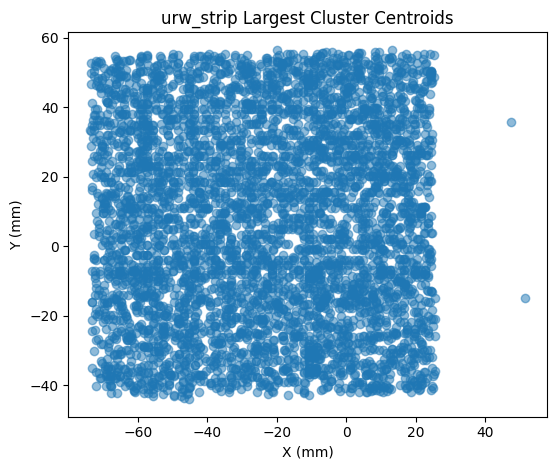

In [5]:
sigmas_x, sigma_x_errs = [], []
sigmas_y, sigma_y_errs = [], []
for v in drift_vs:
    sub_run_name = f'drift_{v}'
    data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
    ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
    m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'
    
    print(f'Getting ray data...')
    ray_data = M3RefTracking(m3_dir, single_track=True, file_nums=file_nums)
    
    det_config = det_config_loader.get_det_config(detector, sub_run_name=sub_run_name)
    det = DreamDetector(config=det_config)
    det.load_dream_data(data_dir, ped_dir, 5, file_nums, chunk_size, save_waveforms=False, waveform_fit_func='parabola_vectorized')
    det.dream_data.correct_for_fine_timestamps()
    det.make_sub_detectors()
    det.read_det_alignment_from_file(alignment_file)
    
    for sub_det in det.sub_detectors:
        print(f'SubDet: {sub_det.sub_index}')
        print(f'x_times shape: {sub_det.x_times.shape}')
        print(f'y_times shape: {sub_det.y_times.shape}')
        print(f'x_times: {sub_det.x_times}')
        print(f'y_times: {sub_det.y_times}')
    
    # in_range = False  # If True, filter hits in range, if False, filter hits out of range
    # # x_ray_bounds, y_ray_bounds = [-30, 30], [-30, 30]
    # x_ray_bounds, y_ray_bounds = [-62, 42], [-40, 45]
    # ray_events = filter_ray_xy(ray_data, det.center[2], x_ray_bounds, y_ray_bounds)
    # if in_range:
    #     dream_data_indices = np.where(np.isin(det.dream_data.event_nums, ray_events))[0]
    
    det.plot_centroids_2d()
    
    # sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=300, plot=True)
    # plt.title(f'Time of Max for {detector} X Strips Drift Voltage: {v}V')
    # sigmas_x.append(sigma_x)
    # sigma_x_errs.append(sigma_x_err)
    # 
    # sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=300, plot=True)
    # plt.title(f'Time of Max for {detector} Y Strips Drift Voltage: {v}V')
    # sigmas_y.append(sigma_y)
    # sigma_y_errs.append(sigma_y_err)   
    

ValueError: 'x' and 'y' must have the same size

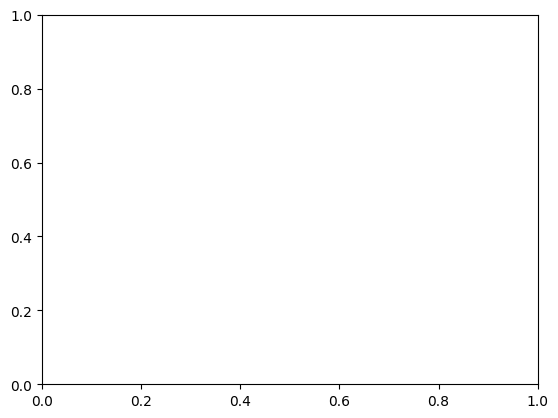

In [6]:
fig, ax = plt.subplots()
ax.errorbar(drift_vs, sigmas_x, yerr=sigma_x_errs, fmt='o', label='X Strips')
ax.errorbar(drift_vs, sigmas_y, yerr=sigma_y_errs, fmt='o', label='Y Strips')
ax.set_xlabel('Drift Voltage [V]')
ax.set_ylabel('Time Resolution [ns]')
ax.set_title(f'Time Resolution vs Drift Voltage for {detector}')
ax.legend()